# Explorative analysis to develop model to substitute bottomPlateHeaterEnable with outsideTemperature
Multiple months of Historical data does not contain the hp1.bottomPlateHeaterEnable or hp2.bottomPlateHeaterEnable flag.  
This document aims to research the possible substitution of this parameter with hp1.outsideTemperature or hp2.outsideTemperature.  
  
The bottomPlateheaterEnable is:
- always off when powerInput = 0 or outsideTemperature > 7
- When powerInput > 0
    - always on when outsideTemperature <= 4 degC
    - partly on when 4 degC < outsideTemperature < 7 degC (for this part, multiple formulas will be fit to determine the best way to model this behaviour)

In [8]:
from quatt_aws_utils.s3 import create_s3_client
import boto3
from datetime import datetime, timedelta
import pandas as pd
import pickle
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import json
import gzip
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [4]:
# load csv files from live data data archive to estimate model
cics = [
        'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6', 
        'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c',
        'CIC-7eede49c-42c2-5b41-94aa-481dad189abf', # 8kW
        'CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea' # 8kW
        ]

path_live_data = os.path.join(os.path.split(os.getcwd())[0], 'data')
print(path_live_data)

for cic in cics:
        if cic == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6':
                X_train = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-X_train-april.csv'))
                X_test = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-X_test-april.csv'))
                y_train = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-y_train-april.csv'))
                y_test = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-y_test-april.csv'))
                energy_train = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-energy_train-april.csv'))
                energy_test = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6energy_test-april.csv'))
        else:
                X_train = pd.concat([X_train, pd.read_csv(os.path.join(path_live_data, f'{cic}-X_train-april.csv'))], ignore_index=True)
                X_test = pd.concat([X_test, pd.read_csv(os.path.join(path_live_data, f'{cic}-X_test-april.csv'))], ignore_index=True)
                y_train = pd.concat([y_train, pd.read_csv(os.path.join(path_live_data, f'{cic}-y_train-april.csv'))], ignore_index=True)
                y_test = pd.concat([y_test, pd.read_csv(os.path.join(path_live_data, f'{cic}-y_test-april.csv'))], ignore_index=True)
                energy_train = pd.concat([energy_train, pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_train-april.csv'))], ignore_index=True)
                energy_test = pd.concat([energy_test, pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_test-april.csv'))], ignore_index=True)

/Users/noutneijmeijer/Documents/quatt_data_analysis/power-energy-calculations/data


### Comparison of static & dynamic model based on outside temparature

In [ ]:
# make x and y dataframes for both testing and training
df_temperatureOutside = pd.concat([X_train['temperatureOutside'], X_test['temperatureOutside']], ignore_index=True)
df_bottomPlateHeaterEnable = pd.concat([X_train['bottomPlateHeaterEnable'], X_test['bottomPlateHeaterEnable']], ignore_index=True)

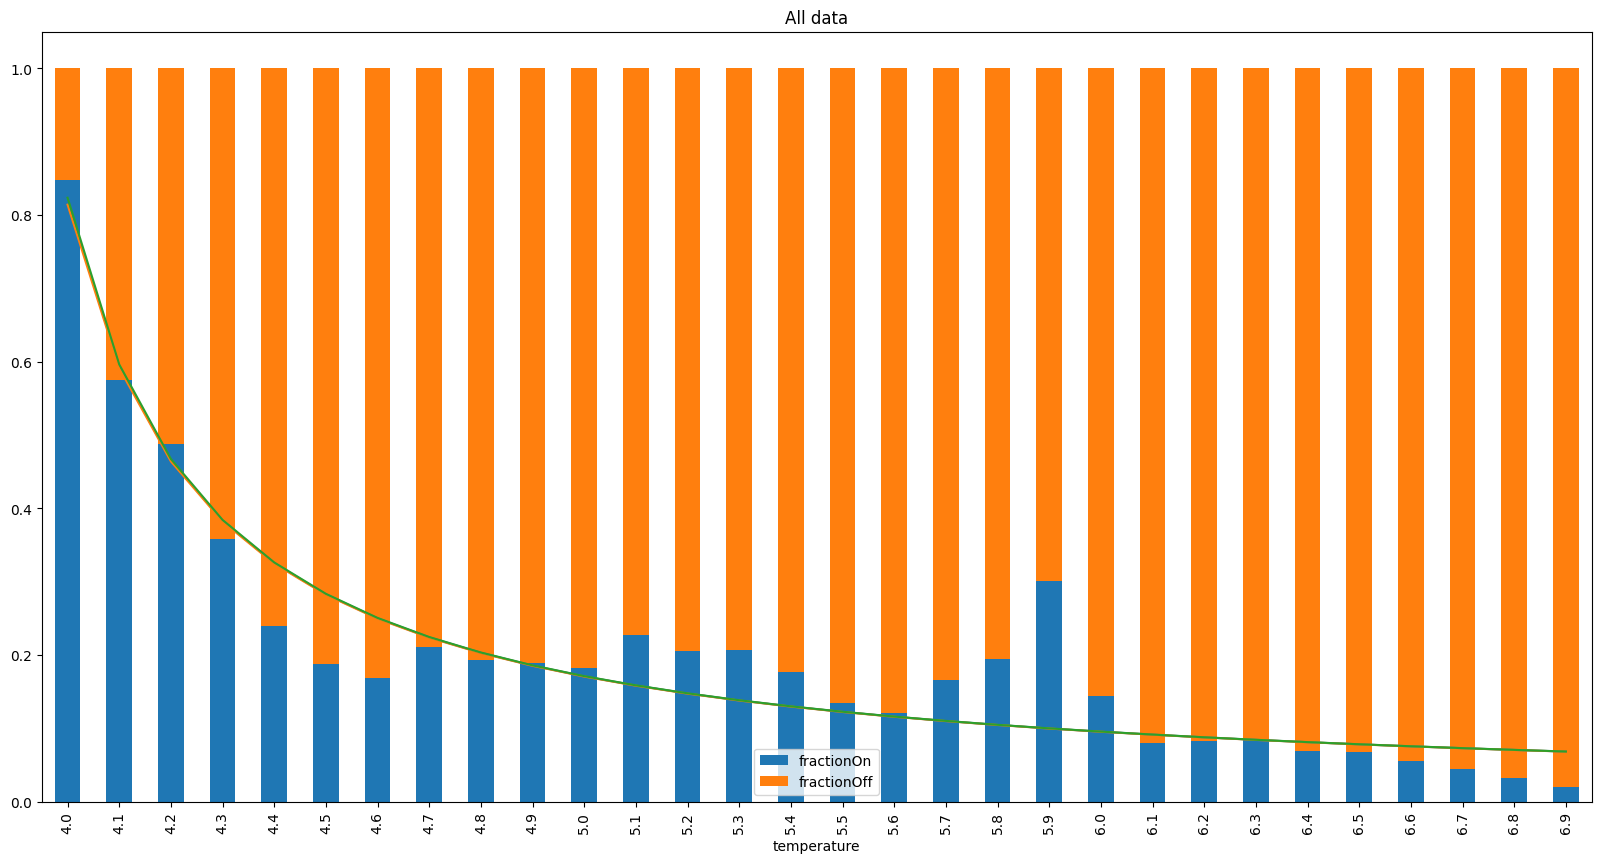

[4.09679457 4.63034307 4.62251133]
[4.39633769 4.63602296 4.68331436]
[4.41763587 4.63332574 4.6898328 ]


In [9]:
# fit curve for 4-7 degrees temperature interval for full data set
def fit_curve(df, func, min_temp=4, max_temp=7):
    temperatures = df[(df['qc.hp1PowerInput']>0) &
                       (df['hp1.temperatureOutside'] < max_temp) &
                       (df['hp1.temperatureOutside'] > min_temp)]['hp1.temperatureOutsideRounded'].sort_values().unique()
    df_counts = pd.DataFrame(temperatures, columns=['temperature'])
    df_counts['countHeatCoilOn'] = df_counts['temperature'].apply(lambda x: len(df[(df['qc.hp1PowerInput']>0) &
                                                                                        (df['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (df['hp1.bottomPlateHeaterEnable'] == 1)]))
    df_counts['countHeatCoilOff'] = df_counts['temperature'].apply(lambda x: len(df[(df['qc.hp1PowerInput']>0) &
                                                                                        (df['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (df['hp1.bottomPlateHeaterEnable'] == 0)]))
    df_counts['fractionOn'] = df_counts['countHeatCoilOn'] / (df_counts['countHeatCoilOn'] + df_counts['countHeatCoilOff'])
    popt, pcov = curve_fit(func, df_counts['temperature'], df_counts['fractionOn'])
    return popt

# set temperatures and curve fit also try: gaussian mixture model, random forest regression version, support vector regression
def func(x, a, b, c):
    return 1 / (a + b*(x-c))

X_total = pd.concat([X_train, X_test])
X_total['hp1.temperatureOutsideRounded'] = X_total['hp1.temperatureOutside'].apply(lambda x: round(x,1))

popt_total = fit_curve(X_total, func)

# random train test split and fit new curves
X_train_popt, X_test_popt = train_test_split(X_total, test_size=0.5, random_state=42) # search how to make sure that the split of data contains an equal amount of temperatures (4-7 degrees)
# use group shuffle split

popt_train = fit_curve(X_train_popt, func)
popt_test = fit_curve(X_test_popt, func)

# plot curves
temperatures = X_total[(X_total['qc.hp1PowerInput']>0) &
            (X_total['hp1.temperatureOutside'] < 7) &
            (X_total['hp1.temperatureOutside'] > 4)]['hp1.temperatureOutsideRounded'].sort_values().unique()
heatcoil_df = pd.DataFrame(temperatures, columns=['temperature'])
heatcoil_df['countHeatCoilOn'] = heatcoil_df['temperature'].apply(lambda x: len(X_total[(X_total['qc.hp1PowerInput']>0) &
                                                                                        (X_total['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_total['hp1.bottomPlateHeaterEnable'] == 1)]))
heatcoil_df['countHeatCoilOff'] = heatcoil_df['temperature'].apply(lambda x: len(X_total[(X_total['qc.hp1PowerInput']>0) &
                                                                                        (X_total['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_total['hp1.bottomPlateHeaterEnable'] == 0)]))
heatcoil_df['fractionOn'] = heatcoil_df['countHeatCoilOn'] / (heatcoil_df['countHeatCoilOn'] + heatcoil_df['countHeatCoilOff'])
heatcoil_df['fractionOff'] = heatcoil_df['countHeatCoilOff'] / (heatcoil_df['countHeatCoilOn'] + heatcoil_df['countHeatCoilOff'])
heatcoil_df.set_index('temperature', inplace=True)

ax4 = heatcoil_df[['fractionOn', 'fractionOff']].plot.bar(stacked=True, figsize=[20,10])
ax4.plot(10*(heatcoil_df.index-4), (1/(popt_total[0] + popt_total[1]*(heatcoil_df.index-popt_total[2]))).tolist())
ax4.plot(10*(heatcoil_df.index-4), (1/(popt_test[0] + popt_test[1]*(heatcoil_df.index-popt_test[2]))).tolist())
ax4.plot(10*(heatcoil_df.index-4), (1/(popt_train[0] + popt_train[1]*(heatcoil_df.index-popt_train[2]))).tolist())
plt.title('All data')
plt.show()
print(popt_train)
print(popt_test)
print(popt_total)

In [ ]:
# add temperatures to X data sets for validation
X_train['bottomPlateHeaterEnableCalc1'] = X_train.apply(lambda x: 1 if ((x['hp1.temperatureOutside'] <= 4) & (x['qc.hp1PowerInput'] > 0)) else 0, axis=1)
X_train['bottomPlateHeaterEnableCalc2'] = X_train.apply(lambda x: (1/(popt_total[0]+popt_total[1]*(x['hp1.temperatureOutside']-popt_total[2]))) 
                                                        if ((x['hp1.temperatureOutside'] < 7) & 
                                                            (x['qc.hp1PowerInput'] > 0) & 
                                                            (x['hp1.temperatureOutside'] > 4)) else 0, axis=1)
X_test['bottomPlateHeaterEnableCalc1'] = X_test.apply(lambda x: 1 if ((x['hp1.temperatureOutside'] <= 4) & (x['qc.hp1PowerInput'] > 0)) else 0, axis=1)
X_test['bottomPlateHeaterEnableCalc2'] = X_test.apply(lambda x: (1/(popt_total[0]+popt_total[1]*(x['hp1.temperatureOutside']-popt_total[2]))) 
                                                        if ((x['hp1.temperatureOutside'] < 7) & 
                                                            (x['qc.hp1PowerInput'] > 0) & 
                                                            (x['hp1.temperatureOutside'] > 4)) else 0, axis=1)

#### Exploring different curve fits for heatCoilEnable

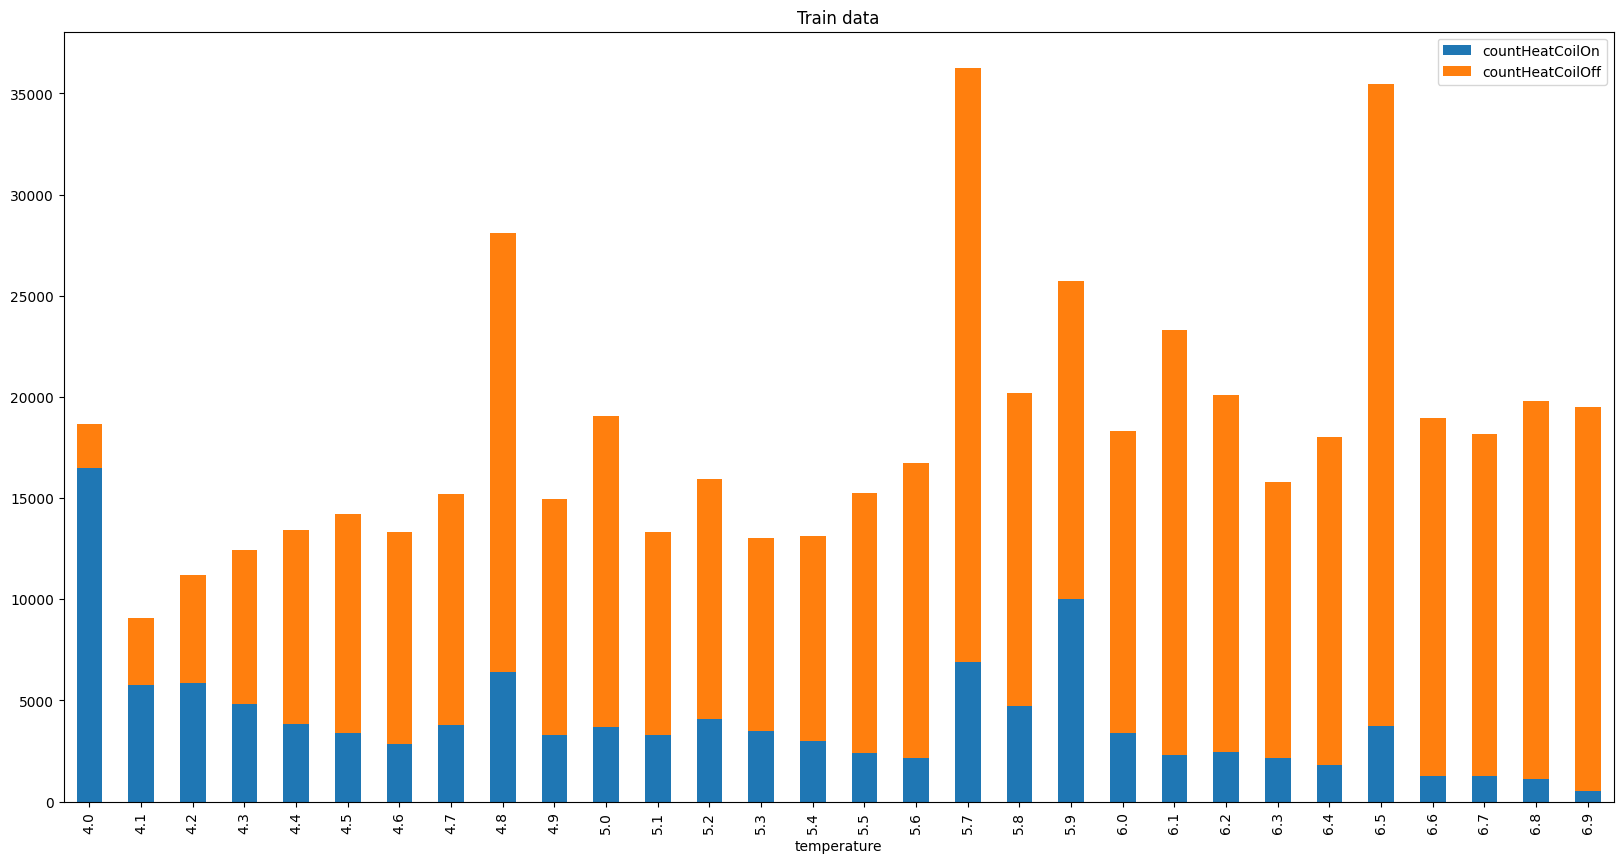

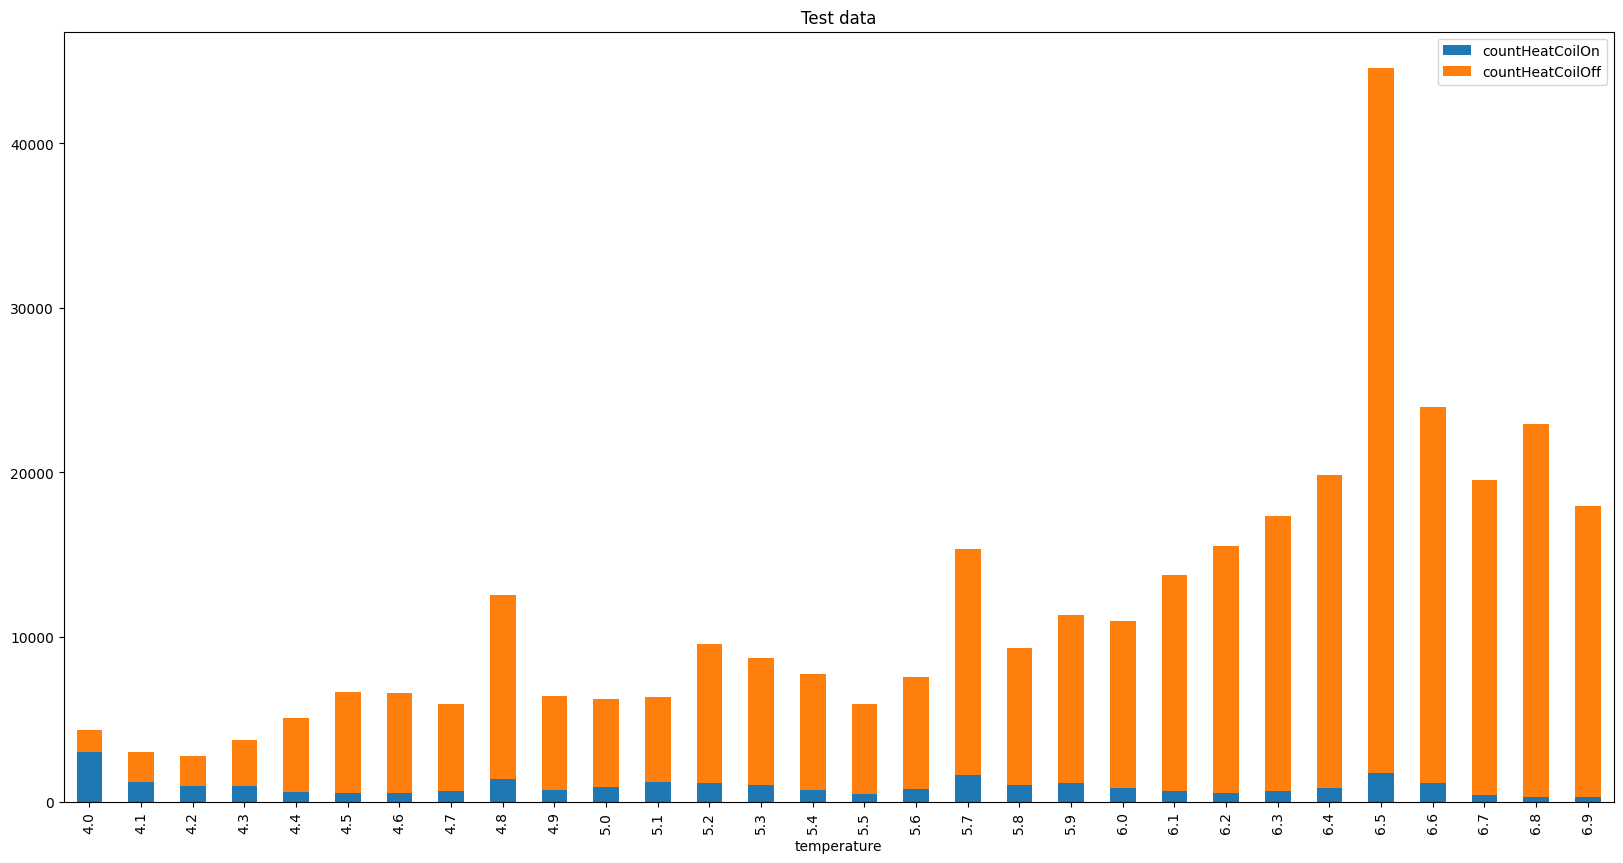

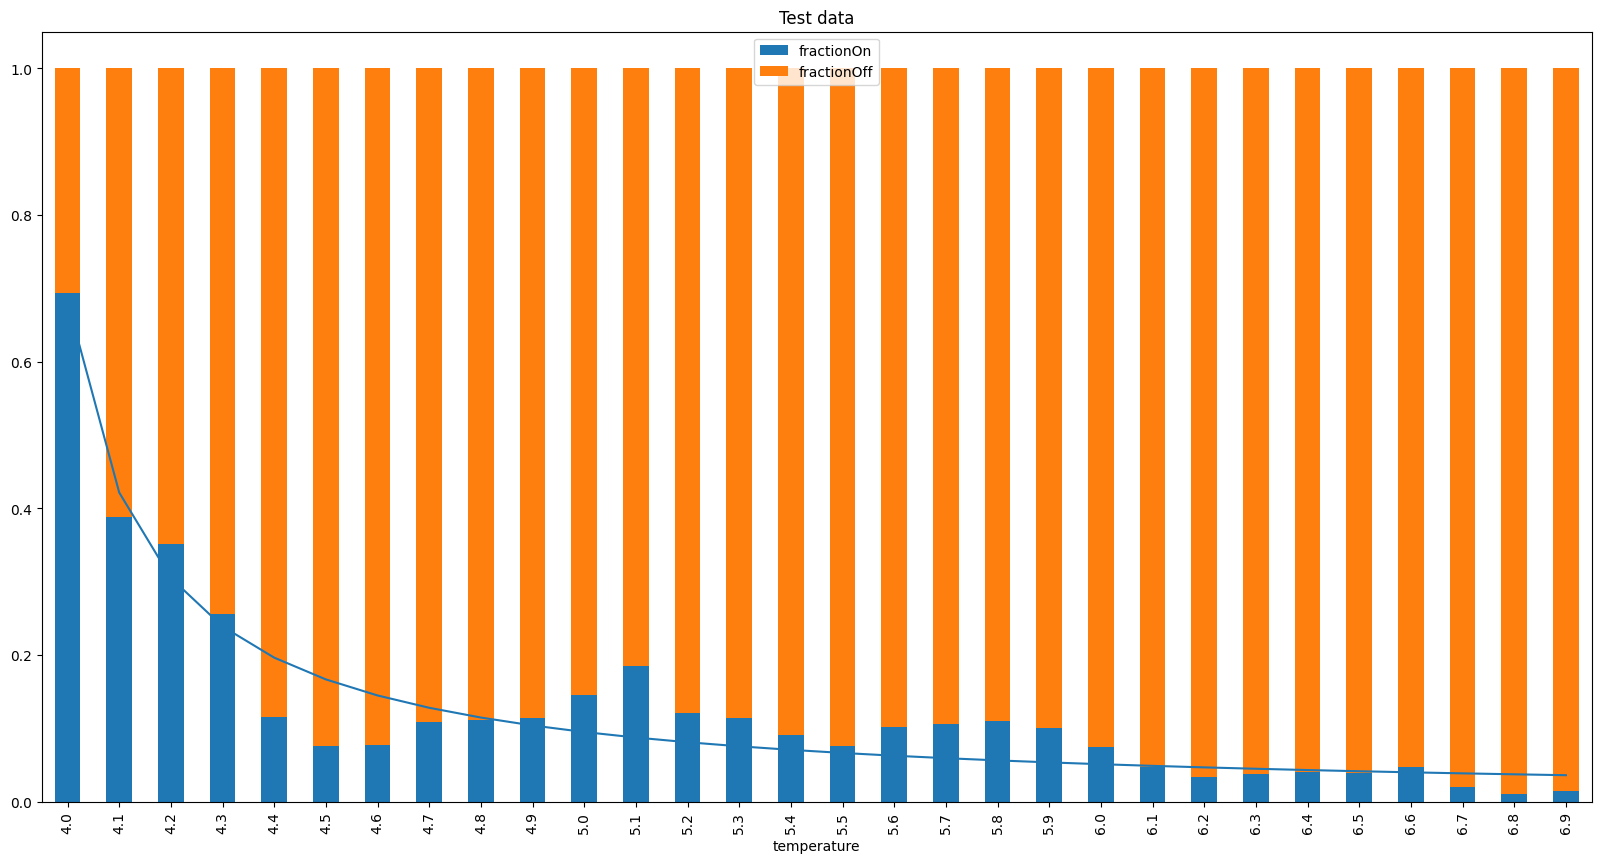

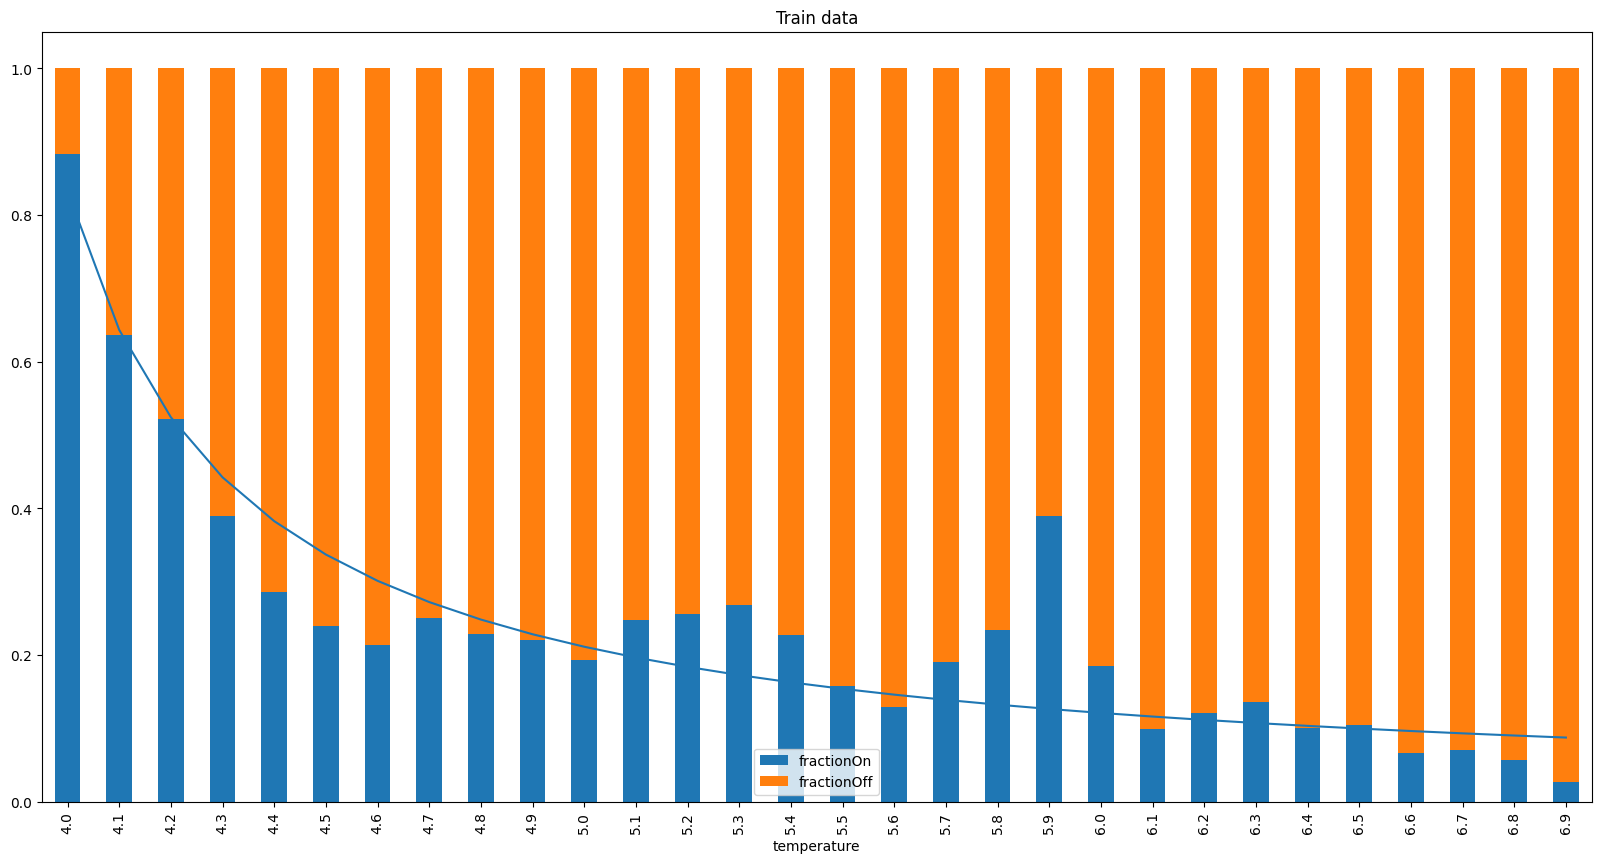

In [ ]:
# check how we can statically model heatCoil on based on outside temperature
X_train['hp1.temperatureOutsideRounded'] = X_train['hp1.temperatureOutside'].apply(lambda x: round(x,1))
X_test['hp1.temperatureOutsideRounded'] = X_test['hp1.temperatureOutside'].apply(lambda x: round(x,1))
temperatures = X_train[(X_train['qc.hp1PowerInput']>0) &
                       (X_train['hp1.temperatureOutside'] < 7) &
                       (X_train['hp1.temperatureOutside'] > 4)]['hp1.temperatureOutsideRounded'].sort_values().unique()

heatcoil_df_train = pd.DataFrame(temperatures, columns=['temperature'])
heatcoil_df_train['countHeatCoilOn'] = heatcoil_df_train['temperature'].apply(lambda x: len(X_train[(X_train['qc.hp1PowerInput']>0) &
                                                                                        (X_train['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_train['hp1.bottomPlateHeaterEnable'] == 1)]))
heatcoil_df_train['countHeatCoilOff'] = heatcoil_df_train['temperature'].apply(lambda x: len(X_train[(X_train['qc.hp1PowerInput']>0) &
                                                                                        (X_train['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_train['hp1.bottomPlateHeaterEnable'] == 0)]))
heatcoil_df_train['fractionOn'] = heatcoil_df_train['countHeatCoilOn'] / (heatcoil_df_train['countHeatCoilOn'] + heatcoil_df_train['countHeatCoilOff'])
heatcoil_df_train['fractionOff'] = heatcoil_df_train['countHeatCoilOff'] / (heatcoil_df_train['countHeatCoilOn'] + heatcoil_df_train['countHeatCoilOff'])
heatcoil_df_train.set_index('temperature', inplace=True)

heatcoil_df_test = pd.DataFrame(temperatures, columns=['temperature'])
heatcoil_df_test['countHeatCoilOn'] = heatcoil_df_test['temperature'].apply(lambda x: len(X_test[(X_test['qc.hp1PowerInput']>0) &
                                                                                        (X_test['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_test['hp1.bottomPlateHeaterEnable'] == 1)]))
heatcoil_df_test['countHeatCoilOff'] = heatcoil_df_test['temperature'].apply(lambda x: len(X_test[(X_test['qc.hp1PowerInput']>0) &
                                                                                        (X_test['hp1.temperatureOutsideRounded'] == x) &
                                                                                        (X_test['hp1.bottomPlateHeaterEnable'] == 0)]))
heatcoil_df_test['fractionOn'] = heatcoil_df_test['countHeatCoilOn'] / (heatcoil_df_test['countHeatCoilOn'] + heatcoil_df_test['countHeatCoilOff'])
heatcoil_df_test['fractionOff'] = heatcoil_df_test['countHeatCoilOff'] / (heatcoil_df_test['countHeatCoilOn'] + heatcoil_df_test['countHeatCoilOff'])
heatcoil_df_test.set_index('temperature', inplace=True)

# create absolute and relative stacked bar plots


ax1 = heatcoil_df_train[['countHeatCoilOn', 'countHeatCoilOff']].plot.bar(stacked=True, figsize=[20,10])
plt.title('Train data')
plt.show()
ax3 = heatcoil_df_test[['countHeatCoilOn', 'countHeatCoilOff']].plot.bar(stacked=True, figsize=[20,10])
plt.title('Test data')
plt.show()

popt, pcov = curve_fit(func, heatcoil_df_test.index, heatcoil_df_test['fractionOn'])
ax4 = heatcoil_df_test[['fractionOn', 'fractionOff']].plot.bar(stacked=True, figsize=[20,10])
ax4.plot(10*(heatcoil_df_test.index-4), (1/(popt[0] + popt[1]*(heatcoil_df_test.index-popt[2]))).tolist())
plt.title('Test data')
plt.show()
popt, pcov = curve_fit(func, heatcoil_df_train.index, heatcoil_df_train['fractionOn'])
ax2 = heatcoil_df_train[['fractionOn', 'fractionOff']].plot.bar(stacked=True, figsize=[20,10])
ax2.plot(10*(heatcoil_df_train.index-4), (1/(popt[0] + popt[1]*(heatcoil_df_train.index-popt[2]))).tolist())
plt.title('Train data')
plt.show()





[-29.44887825   7.54302532  -0.03823821]


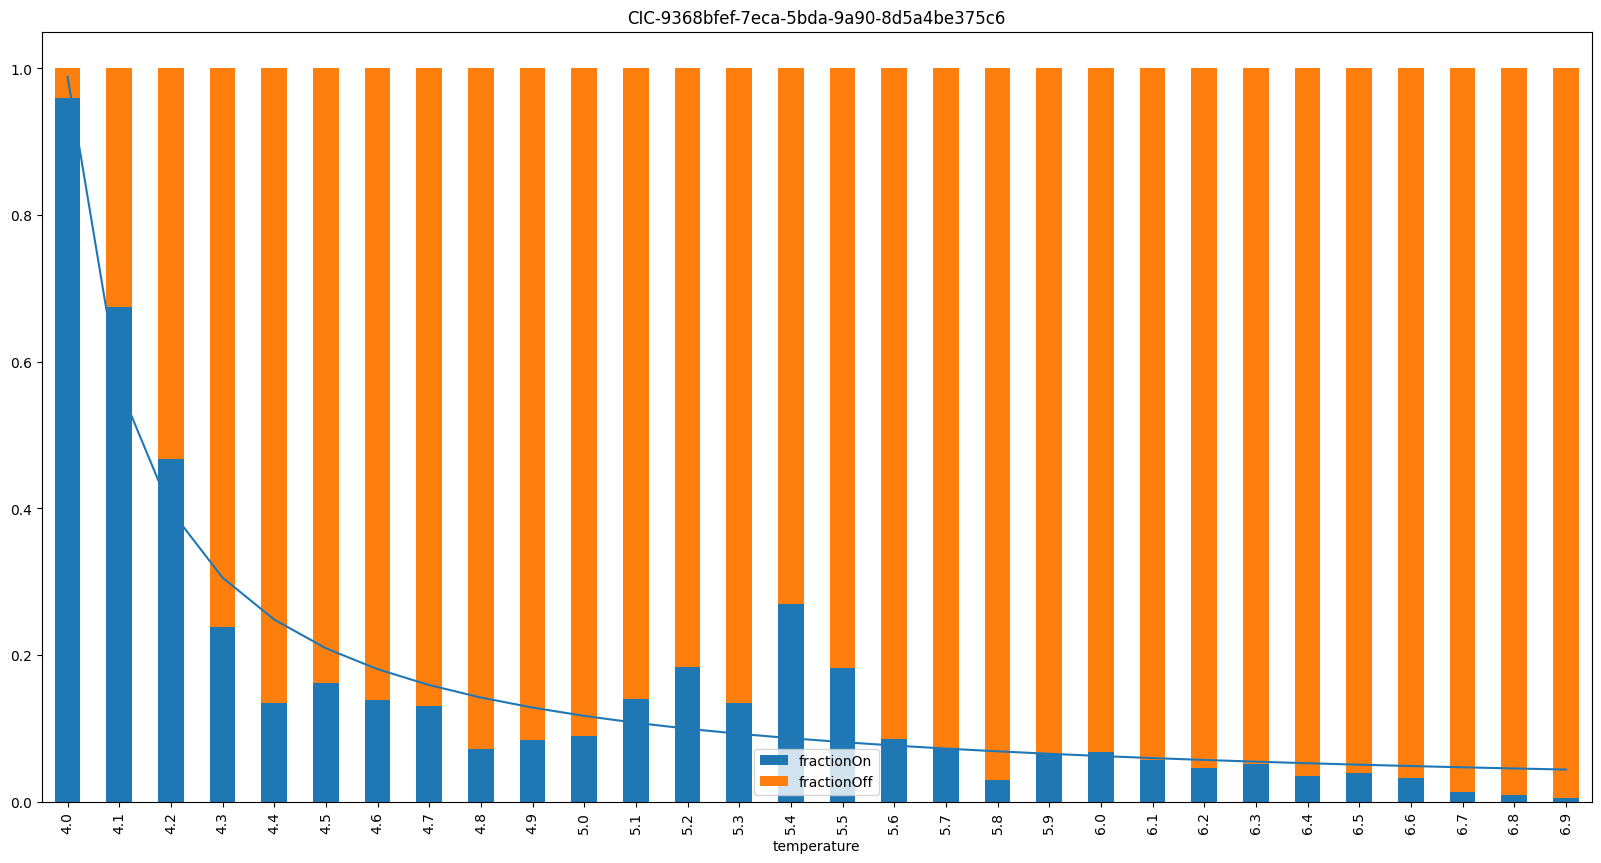

[-6.54432216  2.46484055  0.98974868]


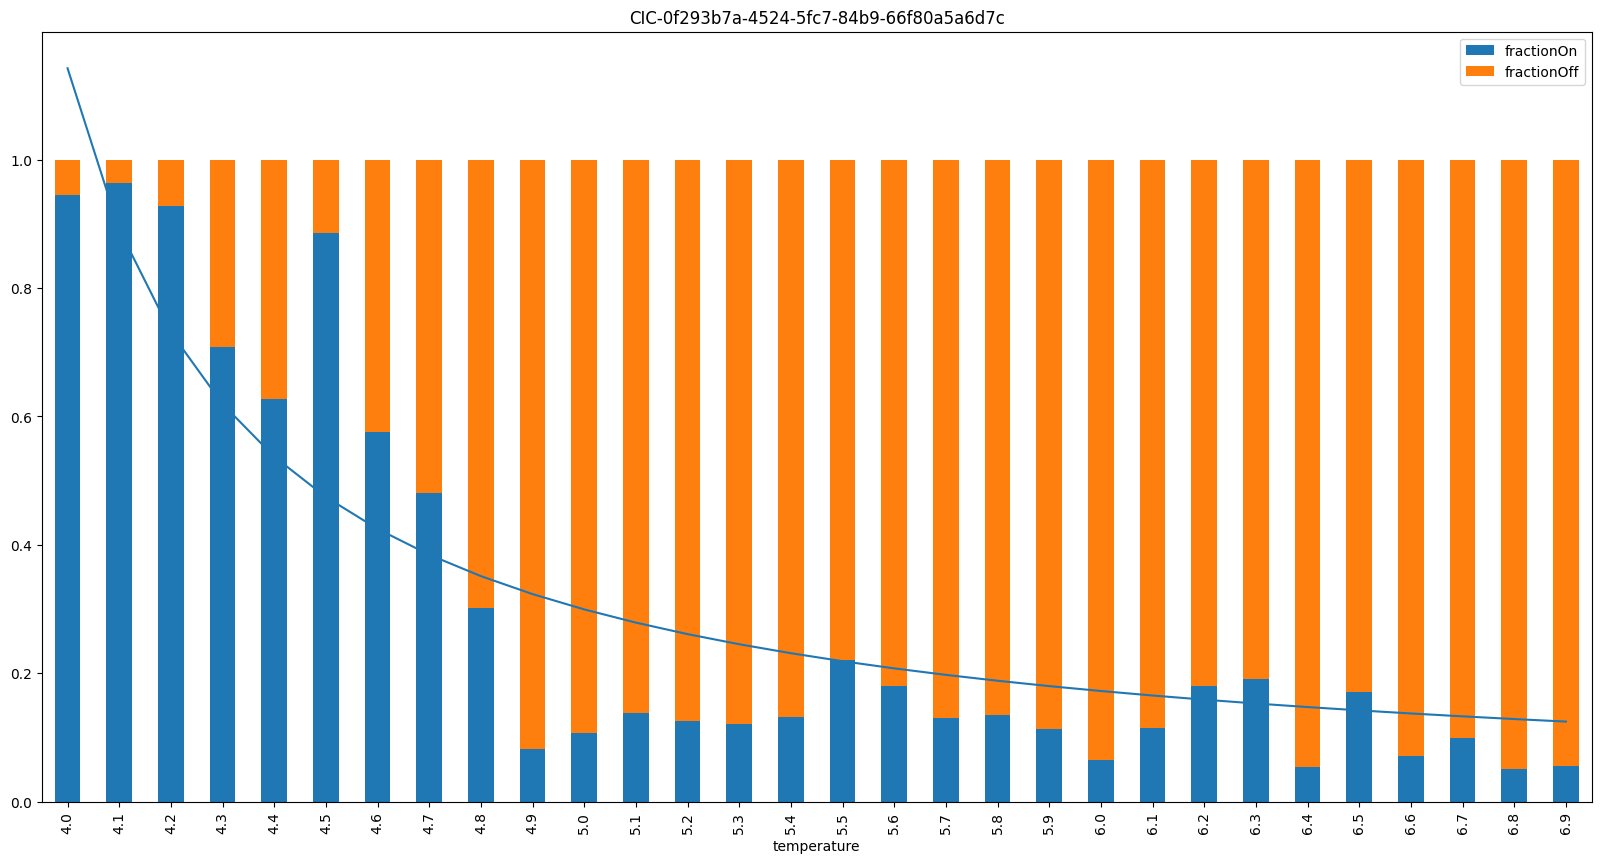

[0.41363317 1.16854368 2.75082684]


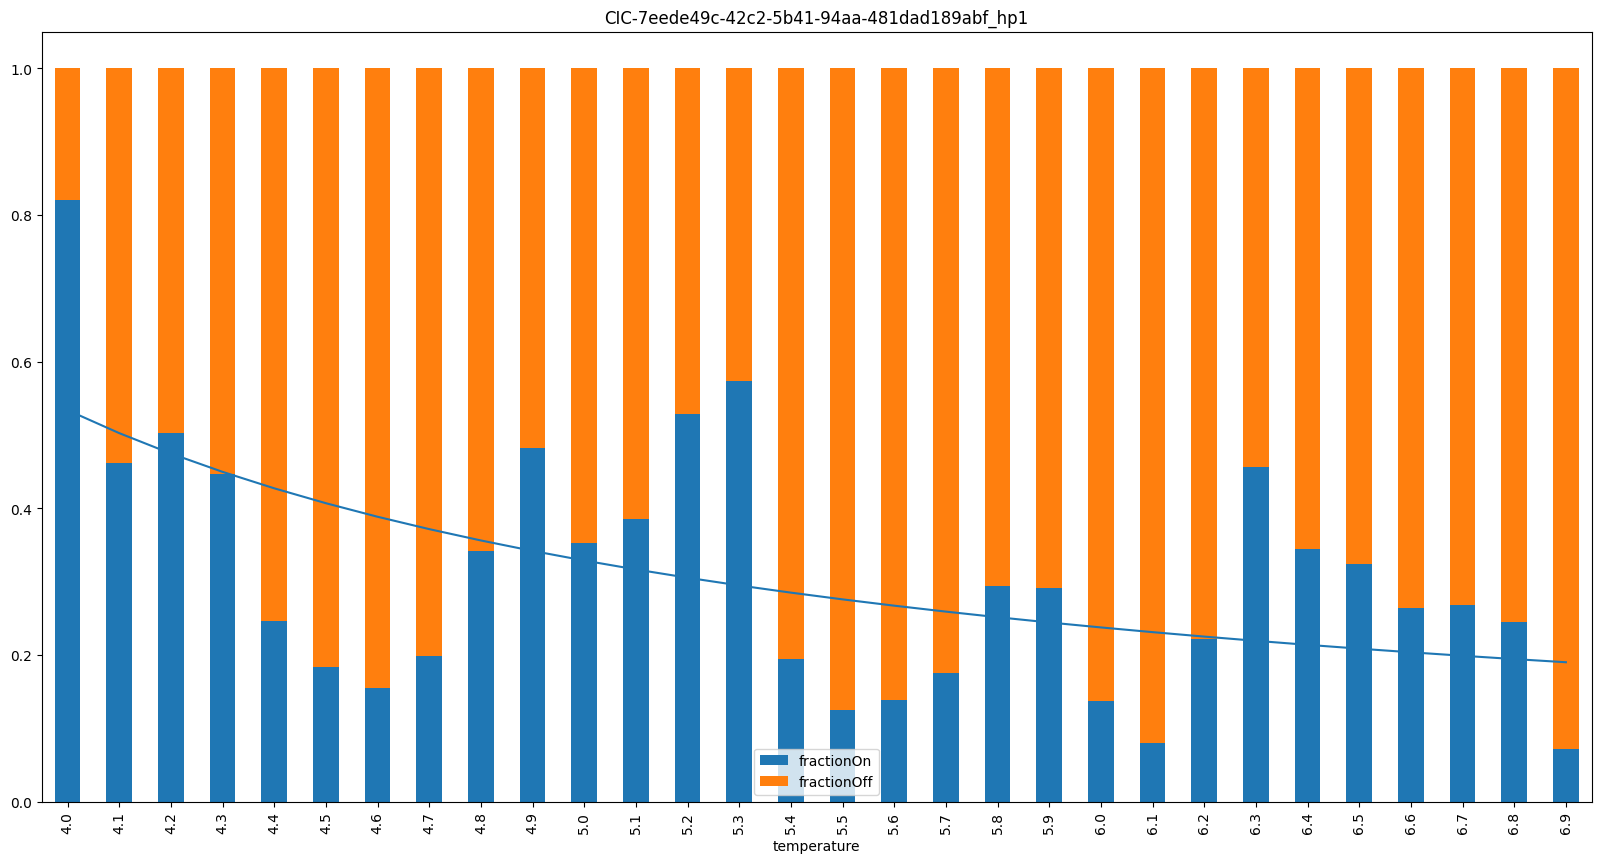

[11.60864281  0.67816353 18.63582095]


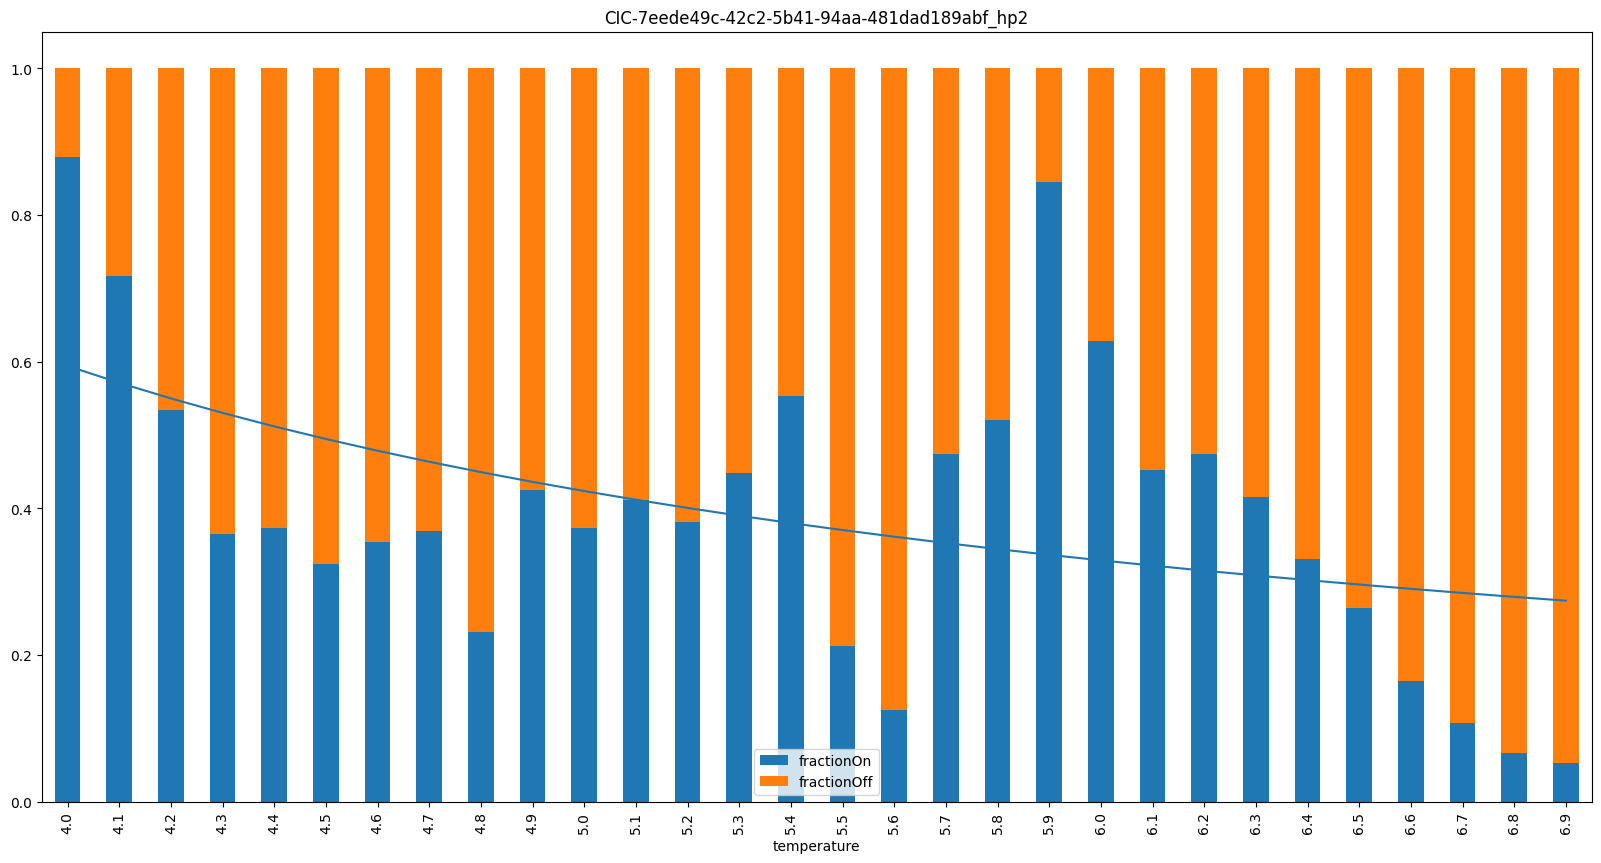

[9.70148334 5.01419571 5.71689536]


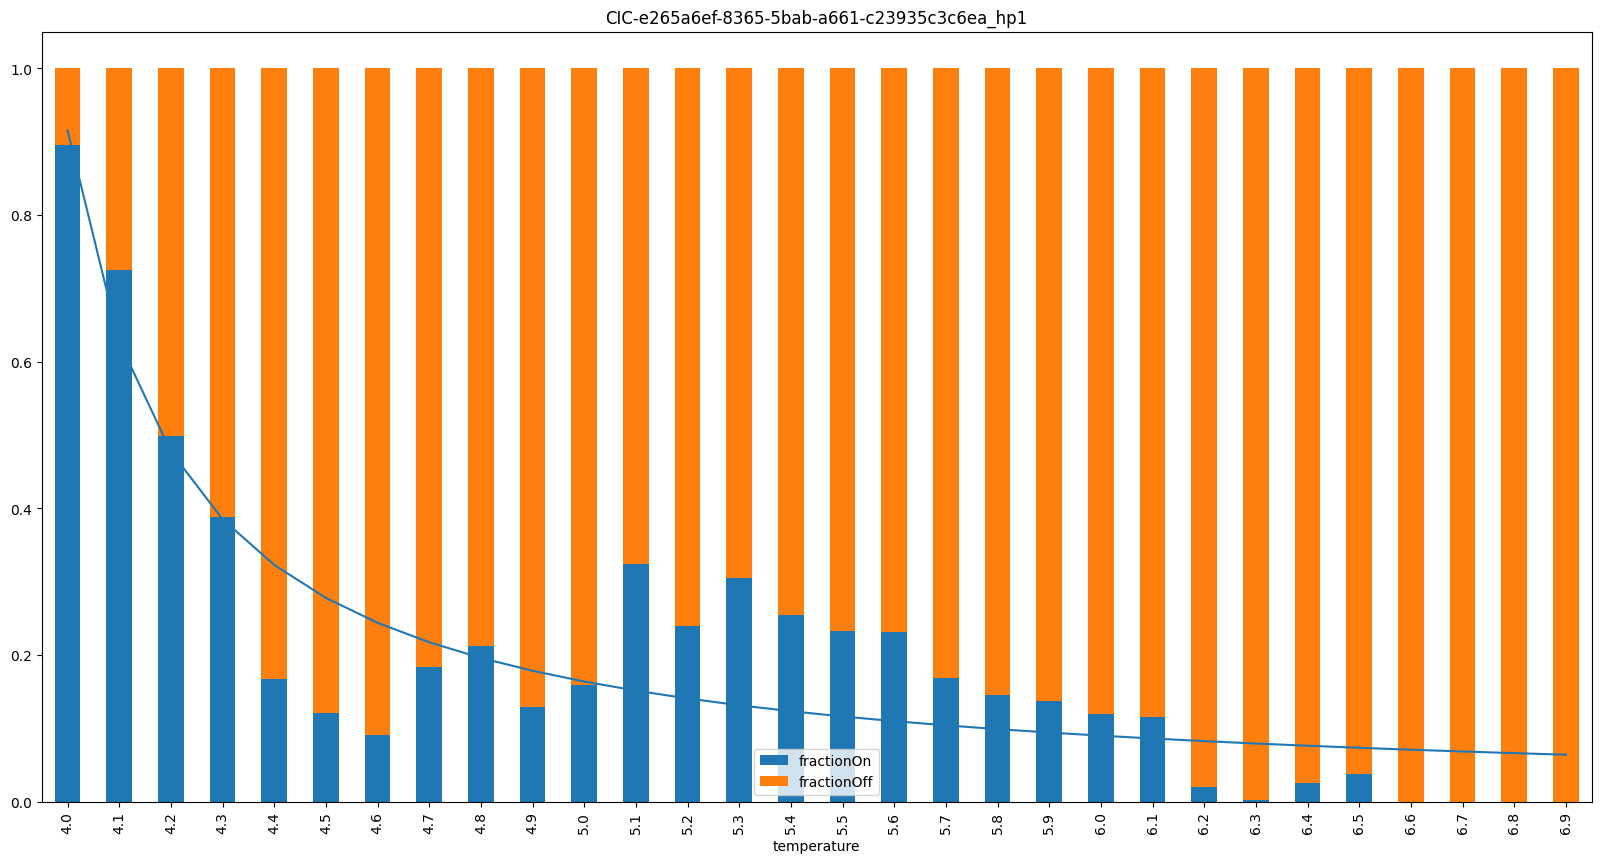

[ 5.4316412  10.40033601  4.38215777]


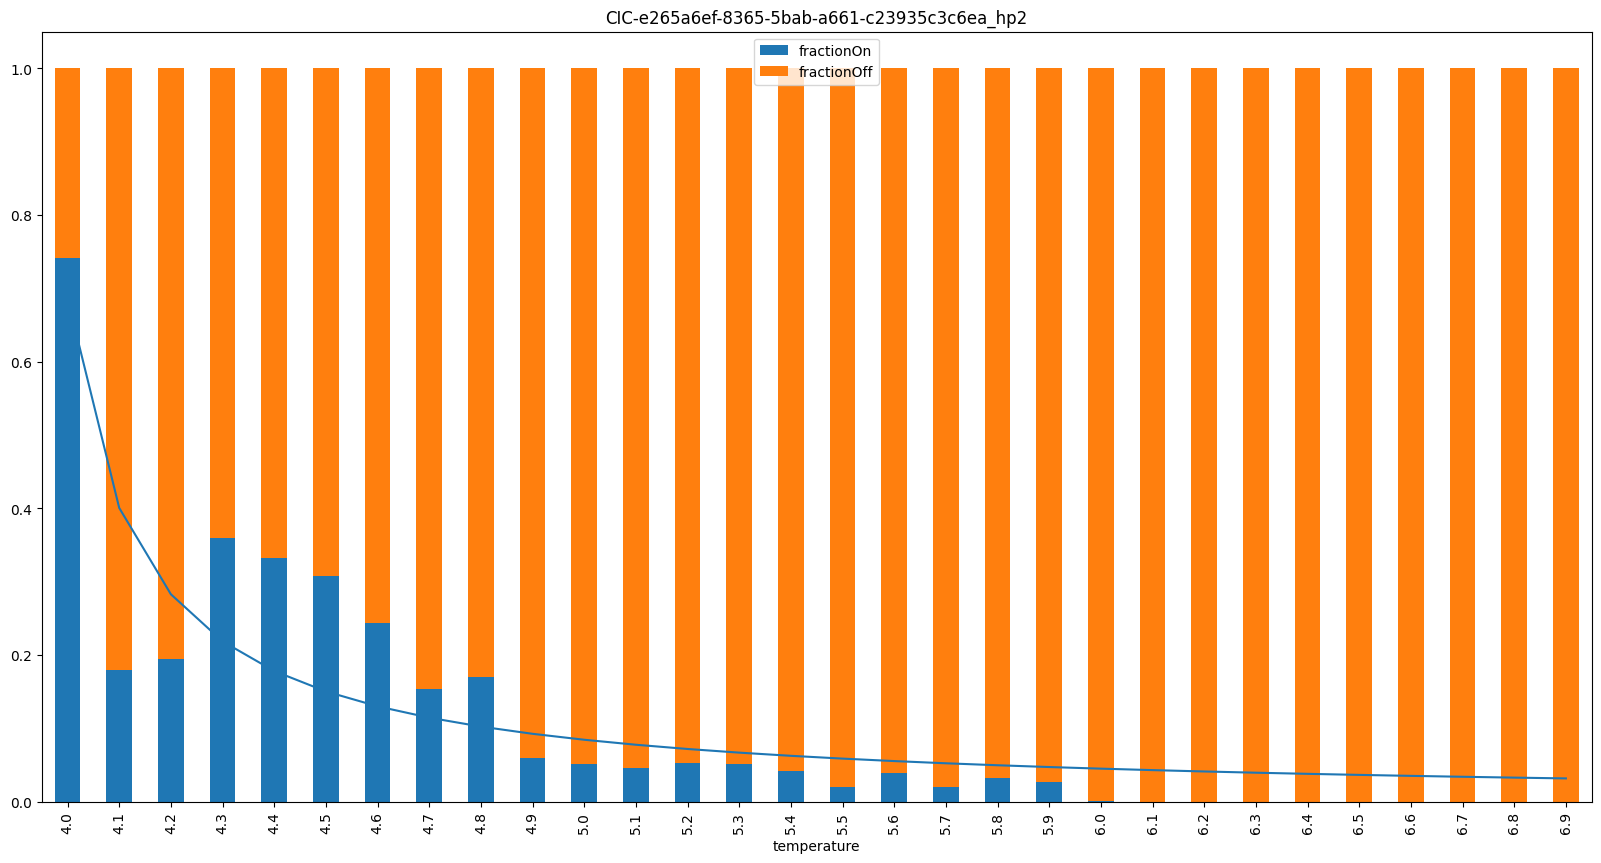

In [ ]:
# comparison of bar plots for each seperate cic
energyX_train = energy_train.join(X_train)
for cic in energyX_train['system.quattId'].unique():
    heatcoil_df = pd.DataFrame(temperatures, columns=['temperature'])

    heatcoil_df['countHeatCoilOn'] = heatcoil_df['temperature'].apply(lambda x: len(energyX_train[(energyX_train['qc.hp1PowerInput']>0) &
                                                                                            (energyX_train['hp1.temperatureOutsideRounded'] == x) &
                                                                                            (energyX_train['hp1.bottomPlateHeaterEnable'] == 1) &
                                                                                            (energyX_train['system.quattId'] == cic)]))
    heatcoil_df['countHeatCoilOff'] = heatcoil_df['temperature'].apply(lambda x: len(energyX_train[(energyX_train['qc.hp1PowerInput']>0) &
                                                                                            (energyX_train['hp1.temperatureOutsideRounded'] == x) &
                                                                                            (energyX_train['hp1.bottomPlateHeaterEnable'] == 0) &
                                                                                            (energyX_train['system.quattId'] == cic)]))
    heatcoil_df['fractionOn'] = heatcoil_df['countHeatCoilOn'] / (heatcoil_df['countHeatCoilOn'] + heatcoil_df['countHeatCoilOff'])
    heatcoil_df['fractionOff'] = heatcoil_df['countHeatCoilOff'] / (heatcoil_df['countHeatCoilOn'] + heatcoil_df['countHeatCoilOff'])

    # set temperature values as index
    heatcoil_df.set_index('temperature', inplace=True)

    def func(x, a, b, c):
        return 1 / (a + b*(x-c))
    popt, pcov = curve_fit(func, heatcoil_df.index, heatcoil_df['fractionOn'])
    print(popt)

    # create absolute and relative stacked bar plots
    ax2 = heatcoil_df[['fractionOn', 'fractionOff']].plot.bar(stacked=True, figsize=[20,10])
    ax2.plot(10*(heatcoil_df.index-4), (1/(popt[0] + popt[1]*(heatcoil_df.index-popt[2]))).tolist())
    plt.title(cic)
    # ax2.plot(heatcoil_df.index.tolist(), (1/(1.11 + 4.63*(heatcoil_df.index-4))).tolist())
    plt.show()